In [3]:
# pip install
#!pip install -r requirements.txt

# Imports
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from pprint import pprint

# Module imports
from periodic_table import *
from utils import *
print("Imported all.")

Imported all.


In [4]:
# Open propmt TPC data file
file_dir = "./assets/A_Z_count-TPC_prompt.txt"
columns = ["Mass Number", "Atomic Number", "Counts"]
df_prompt = open_data(file_dir, columns)
# Add in isotope data
add_isotope_data(df_prompt)
# Reorder columns
df_prompt = df_prompt[["Symbol","Iso Symbol","Atomic Number","Mass Number","Counts","Production Yield","Stable","Half Life","Decay Modes (m, b, q MeV)","Max Q-Value","Plot Colour",]]
# df_prompt.tail(20)

In [5]:
# Open delayed TPC data file
file_dir = "./assets/A_Z_count-TPC_delayed.txt"
columns = ["Mass Number", "Atomic Number", "Counts"]
df_delayed = open_data(file_dir, columns)
# Add in isotope data
add_isotope_data(df_delayed)
# Reorder columns
df_delayed = df_delayed[["Symbol","Iso Symbol","Atomic Number","Mass Number","Counts","Production Yield","Stable","Half Life","Decay Modes (m, b, q MeV)","Max Q-Value","Plot Colour",]]
# df_delayed.tail(20)

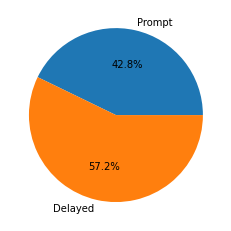

In [6]:
# Ratio of prompt to delayed counts
plt.pie(x=[df_prompt["Counts"].sum(), df_delayed["Counts"].sum()], autopct='%1.1f%%', labels=["Prompt", "Delayed"])
plt.show()

In [12]:
# Open buffer data file
file_dir = "./assets/A_Z_count-buffers.txt"
columns = ["Mass Number", "Atomic Number", "Counts"]
df_buffers = open_data(file_dir, columns)
# Add in isotope data
add_isotope_data(df_buffers)
# Reorder columns
df_buffers = df_buffers[["Symbol","Iso Symbol","Atomic Number","Mass Number","Counts","Production Yield","Stable","Half Life","Decay Modes (m, b, q MeV)","Max Q-Value","Plot Colour",]]
# df_buffers.tail(20)

# Look for high energy gamma in buffer and delayed

In [30]:
# Ignore stable isotopes
stable_buffers = df_buffers[df_buffers["Stable"] == False]
stable_TPC_prompt = df_prompt[df_buffers["Stable"] == False]
stable_TPC_delayed = df_delayed[df_buffers["Stable"] == False]

C:\Users\TSBus\AppData\Local\Temp\ipykernel_22332\1809857111.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  stable_TPC_prompt = df_prompt[df_buffers["Stable"] == False]
C:\Users\TSBus\AppData\Local\Temp\ipykernel_22332\1809857111.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  stable_TPC_delayed = df_delayed[df_buffers["Stable"] == False]


In [31]:
stable_buffers = stable_buffers.sort_values("Max Q-Value", ascending=False)
stable_buffers.head(40)

,Symbol,Iso Symbol,Atomic Number,Mass Number,Counts,Production Yield,Stable,Half Life,"Decay Modes (m, b, q MeV)",Max Q-Value,Plot Colour
36,B,B 5-14,5,14,3,1.241304e-07,False,0.01250,"[[B-, 1.0, 20.644]]",20.644,red
24,Li,Li 3-11,3,11,3,1.241304e-07,False,0.00875,"[[B-, 1.0, 20.623], [BN, 0.83, 20.119], [B2N, ...",20.623,red
140,Al,Al 13-36,13,36,1,4.137680e-08,False,0.09000,"[[B-, 1.0, 18.264], [BN, 0.31, 12.071]]",18.264,red
15,B,B 5-8,5,8,16,6.620289e-07,False,0.77000,"[[EC, 1.0, 17.98], [EA, 1.0, 0.0]]",17.980,red
59,N,N 7-20,7,20,3,1.241304e-07,False,0.13600,"[[B-, 1.0, 17.968], [BN, 0.429, 10.359]]",17.968,red
31,N,N 7-12,7,12,1,4.137680e-08,False,0.01100,"[[EC, 1.0, 17.338]]",17.338,red
128,Al,Al 13-34,13,34,6,2.482608e-07,False,0.04200,"[[B-, 1.0, 17.024], [BN, 0.27, 9.489]]",17.024,red
13,Li,Li 3-8,3,8,1002,4.145956e-05,False,0.84000,"[[B-, 1.0, 16.005], [BA, 1.0, 0.0]]",16.005,red
110,Na,Na 11-31,11,31,1,4.137680e-08,False,0.01700,"[[B-, 1.0, 15.872], [BN, 0.37, 13.494], [B2N, ...",15.872,red
100,P,P 15-28,15,28,2,8.275361e-08,False,0.27000,"[[EC, 1.0, 14.334], [EP, 1.3e-05, 2.749], [EA,...",14.334,red


In [29]:
stable_TPC_delayed = stable_TPC_delayed.sort_values("Max Q-Value", ascending=False)
stable_TPC_delayed.head(10)

,Symbol,Iso Symbol,Atomic Number,Mass Number,Counts,Production Yield,Stable,Half Life,"Decay Modes (m, b, q MeV)",Max Q-Value,Plot Colour
3,Li,Li 3-8,3,8,29,3.826473e-06,False,0.8400,"[[B-, 1.0, 16.005], [BA, 1.0, 0.0]]",16.005,red
32,F,F 9-24,9,24,2,2.638947e-07,False,0.3900,"[[B-, 1.0, 13.511], [BN, 0.059000000000000004,...",13.511,red
9,B,B 5-12,5,12,3,3.958421e-07,False,0.0202,"[[B-, 1.0, 13.369], [B3A, 0.0158, 0.0]]",13.369,red
68,Si,Si 14-35,14,35,3,3.958421e-07,False,0.7800,"[[B-, 1.0, 10.497], [BN, 0.05, 10.497]]",10.497,red
15,N,N 7-16,7,16,10,1.319474e-06,False,7.1300,"[[B-, 1.0, 10.421], [BA, 1.1999999999999999e-0...",10.421,red
72,P,P 15-36,15,36,64,8.444631e-06,False,5.6000,"[[B-, 1.0, 10.413]]",10.413,red
50,Al,Al 13-30,13,30,41,5.409842e-06,False,3.6200,"[[B-, 1.0, 8.561]]",8.561,red
29,F,F 9-23,9,23,1,1.319474e-07,False,2.2300,"[[B-, 1.0, 8.484]]",8.484,red
53,Al,Al 13-31,13,31,10,1.319474e-06,False,0.6440,"[[B-, 1.0, 7.995]]",7.995,red
46,Mg,Mg 12-29,12,29,7,9.236315e-07,False,1.3000,"[[B-, 1.0, 7.596]]",7.596,red
